In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV



In [2]:
np.random.seed(0)

tr = np.loadtxt('pa2train.txt')
X_train = tr[:, :-1]    #everything except last
Y_train = tr[:, -1]     #last which is the target label

val = np.loadtxt('pa2validation.txt')
X_val = val[:, :-1]
Y_val = val[:, -1]

te = np.loadtxt('pa2test.txt')
X_test = te[:, :-1]
Y_test = te[:, -1]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_val.shape, Y_val.shape, type(X_train)

((2000, 22), (2000,), (1000, 22), (1000,), (1000, 22), (1000,), numpy.ndarray)

### 1. Bagging

In [3]:
import numpy as np

def bagging_data(X, num_bags=10):
    bags = []
    num_samples = X.shape[0]
    for i in range(num_bags):
        bootstrapped_indices = np.random.choice(num_samples, size=num_samples, replace=True)
        bags.append(bootstrapped_indices)

    return bags         # list of 'num_bags' number of lists corresponding to the 10 bags and each sublist has the bootstrapped indices


In [4]:
bags = bagging_data(X_train)
np.array(bags).shape    

(10, 2000)

### 2. Make random forest 

In [5]:
def make_random_forest(X, Y, num_trees, low = 5, high = 15): # we were asked to use 5-15 features
    num_features = X.shape[1]                           #22
    mybags = bagging_data(X, num_trees)
    my_rand_forest = []                                 # I'll be keeping all the trees that comprise my random forest here
    feature_count = np.zeros(num_features)         # we keep track of the count of each feature to help ensure that all features are used at least once
    
    for sublist in mybags:
        bag_X = X[sublist]
        bag_Y = Y[sublist]

        features = np.random.randint(low, high+1)
        selected_features = np.random.choice(num_features, features, replace=False) #randomly selecting features without replacement. Randomly selecting ensures approx equal
        feature_count[selected_features] = feature_count[selected_features] + 1                     

        bag_X = bag_X[:, selected_features] # so that we use only the randomly selected features and not all
        DT = DecisionTreeClassifier(criterion='gini', max_features=features)
        DT.fit(bag_X, bag_Y)

        my_rand_forest.append((DT, selected_features))

    return my_rand_forest, feature_count    

In [6]:
rf, fc = make_random_forest(X_train, Y_train, 10)
min(fc)  # find the number of times the least used feature was used


1.0

In [7]:
rf

[(DecisionTreeClassifier(max_features=13),
  array([16, 20,  2,  5,  4, 14,  1,  6, 17,  7,  8,  3, 13])),
 (DecisionTreeClassifier(max_features=15),
  array([16,  2, 19, 17,  5,  8,  0, 10, 14, 20,  6, 12, 13,  9,  1])),
 (DecisionTreeClassifier(max_features=14),
  array([ 0,  3, 15, 21, 20, 11, 12,  2,  8, 17,  1,  4, 16,  6])),
 (DecisionTreeClassifier(max_features=5), array([ 3,  8,  2,  1, 20])),
 (DecisionTreeClassifier(max_features=8),
  array([16,  4, 19, 11,  2,  7, 17,  3])),
 (DecisionTreeClassifier(max_features=11),
  array([ 9, 21,  3,  2, 12, 17, 11,  7,  4, 15, 20])),
 (DecisionTreeClassifier(max_features=10),
  array([ 0, 17, 14,  8,  6, 11, 20, 15,  1,  5])),
 (DecisionTreeClassifier(max_features=9),
  array([ 2,  7, 15,  1, 10, 14,  0, 16,  8])),
 (DecisionTreeClassifier(max_features=11),
  array([17,  8,  7, 19, 14,  0, 21, 16,  5,  1, 10])),
 (DecisionTreeClassifier(max_features=12),
  array([ 9,  6,  0, 20, 21, 11,  4,  3, 19, 18,  1, 15]))]

### Evaluating and validating RF performance (untuned)

In [8]:
def predict_and_evaluate(random_forest, X_val, y_val):
    predictions = []

    for tree, selected_features in random_forest:
        X_tree = X_val[:, selected_features] #take selected features
        tree_predictions = tree.predict(X_tree) 
        predictions.append(tree_predictions)

    #vote
    final_predictions = np.mean(predictions, axis=0)
    final_predictions = (final_predictions >= 0.5).astype(int) #classes

    
    accuracy = accuracy_score(y_val, final_predictions)
    
    return accuracy

In [9]:
acc = predict_and_evaluate(rf, X_val, Y_val)
print(f"Untuned: {acc}")

Untuned: 0.844


In [10]:
num_trees = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
fts_max = list(range(5, 16))


### figuring out which combination of params (max features and number of trees) give good results

In [11]:
from tqdm import tqdm # for tracking progress since this took some time

accuracy_matrix = np.zeros((len(num_trees), len(fts_max)))

for i in tqdm(range(len(num_trees))):
    for j in range(len(fts_max)):
        my_random_forest, fc = make_random_forest(X_train, Y_train, num_trees[i], fts_max[j])
        accuracy_matrix[i, j] = predict_and_evaluate(my_random_forest, X_val, Y_val)

100%|██████████| 10/10 [01:16<00:00,  7.65s/it]


In [12]:
max_index = np.argmax(accuracy_matrix)
i, j = np.unravel_index(max_index, accuracy_matrix.shape)
num_trees[i], fts_max[j], accuracy_matrix[i, j]

(60, 8, 0.892)

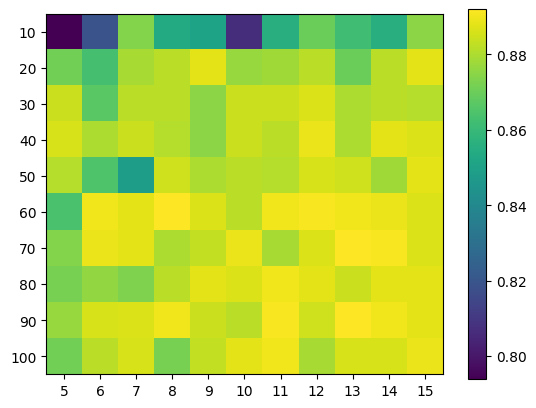

In [13]:

plt.imshow(accuracy_matrix, cmap='viridis', interpolation='nearest')

plt.xticks(np.arange(len(fts_max)), fts_max)
plt.yticks(np.arange(len(num_trees)), num_trees)
plt.colorbar()
plt.show()

In [14]:
rf_tuned, fc = make_random_forest(X_train, Y_train, num_trees[i], fts_max[j], fts_max[j]+1)
acc_rf_tuned = predict_and_evaluate(rf_tuned, X_val, Y_val)
print(f"RF Tuned: {acc_rf_tuned}")

RF Tuned: 0.856


### 4. finding best DT classifier within random forest

In [15]:
def make__better_random_forest(X, Y, num_trees, low = 5, high = 15): # we were asked to use 5-15 features
    num_features = X.shape[1]                           #22
    mybags = bagging_data(X, num_trees)
    my_rand_forest = []                                 # I'll be keeping all the trees that comprise my random forest here
    feature_count = np.zeros(num_features)         # we keep track of the count of each feature to help ensure that all features are used at least once
    
    for sublist in tqdm(mybags):
        bag_X = X[sublist]
        bag_Y = Y[sublist]

        features = np.random.randint(low, high+1)
        selected_features = np.random.choice(num_features, features, replace=False) #randomly selecting features without replacement
        feature_count[selected_features] = feature_count[selected_features] + 1                     

        bag_X = bag_X[:, selected_features] # so that we use only the randomly selected features and not all
        DT = DecisionTreeClassifier(criterion='gini', max_features=features)
        param_grid = {
            'max_depth': [2, 3, 5],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [1, 2, 4],
        }

        grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)
        grid_search.fit(X, Y)

        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_    
        best_model.fit(bag_X, bag_Y)

        my_rand_forest.append((best_model, selected_features))

    return my_rand_forest, feature_count    

In [16]:
tuned_rf, fc = make__better_random_forest(X_train, Y_train, 10) # 10 trees due to time constraints

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


### 5. comparing performance

In [17]:
acc1 = predict_and_evaluate(tuned_rf, X_val, Y_val)
print(f"Untuned: {acc}")
print(f"RF Tuned: {acc_rf_tuned}")
print(f"DT Tuned: {acc1}")

Untuned: 0.844
RF Tuned: 0.856
DT Tuned: 0.842
